# Image Classification

## 1. Introduction

In this project, I classify four types of images using several machine learning algorithms. The dataset includes a set of gray scale images (32 * 32 pixels) with one of the following objects: horse, truck, frog, and ship (labels 0, 1, 2 and 3, respectively). The goal is to train models to recognize which of the objects is presented in each image. 

Here are some samples of the training images, one for each class:

<img src="ImageClass_figure.png">

Before starting, let's import necessary modules and read data:

In [1]:
# Import python modules
import numpy as np
import pandas as pd

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

from IPython.display import display, HTML
import seaborn as sns
import matplotlib.pyplot as plt

# Read in train and test data
def read_image_data():
    temp = np.load('data_features.npz')
    features= temp['features']
    temp = np.load('data_labels.npz')
    labels= temp['labels']
    return (features, labels)

X,y = read_image_data()

### Properties of the dataset

I first printed the shape of the data set to have an idea, and then divided data set into train (80%) and test (20%) sets:

In [2]:
print('\nFeatures data (X) set has a shape of:', X.shape)
print('\nLabels data (y) set has a shape of', y.shape)

#create train and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=23,stratify=y)

#count labels in train and test
train_count=[sum(y_train==i) for i in range(4)]
test_count=[sum(y_test==i) for i in range(4)]
target_names=['horse','truck','frog','ship']
count_df = pd.DataFrame({'Count in train data': train_count,
                         'Count in test data': test_count},
                        index=target_names,
                        columns=['Count in train data','Count in test data'])
count_df.index.name='Image Type'
#without passing column names, it automatically orders column names alphabetically
print("\n\nCount of each class in train and test test\n\n",count_df)


Features data (X) set has a shape of: (20000, 1024)

Labels data (y) set has a shape of (20000,)


Count of each class in train and test test

             Count in train data  Count in test data
Image Type                                         
horse                      4000                1000
truck                      4000                1000
frog                       4000                1000
ship                       4000                1000


## 2. Methodology 

The strategy I used is the following: 

Use __cross validation__ (CV) for each model to choose the best parameters (__hyperparameter tuning__), then train each model with best parameters, and finally make prediction on the test subset. After getting predictions, calculate confusion matrix, classification report, and the accuracy (I will use _accuracy_ as a value of scoring parameter for all models).

The code first creates all classifiers in section 3 below. Then, it trains, predicts, and get results for all in section 4.

Although the above strategy seems straightforward, there are a few important things to decide. I will now discuss these in order of importance.

###  2.1 Which models to train?

There would not be such a question, if the dataset was low-dimensional. We would try as many models as we like, and choose the best one. However, given that our data set is high-dimensional, it would be computationally very expensive to run some models. In addition to computation time, effectiveness of classification algorithms decrease in high-dimensional spaces due to __curse of dimensionality__ phenomena. As dimension of a dataset increases, distance measures, which classification algorithms depend on, become _less_ effective.

Although there is a 'curse of dimensionality' phenomena in high-dimensional spaces, algorithms are affected from this _differently_ depending on the distance measure and search algorithm they use. For instance, KNN classifier with Euclidean distance is affected a lot, since Euclidean distance becomes meaningless at high-dimensional spaces and since KNN uses all features when computing distance. (So, classification algorithms using Euclidean distance but with a _subset of features_ may work fine.)

As dimension of the feature space increaes, percent of data points that stay at corners increases as well. Actually, that is why choosing a linear kernel for support vector machine (SVM) would be better than nonlinear kernels, such as rbf. The data becomes linearly seperable at high dimensions. 
(This does NOT mean that every linear classifier is better than every nonlinear classifier at high-dimensional spaces. For instance, random forest is usually hard to beat, as will be seen here too.)

Considering both computational time and effectiveness issues, I tried these four models for classifying images:

 - Linear SVM (with _stochastic gradient descent_)
 - Logit (with _stochastic gradient descent_)
 - Naive Bayes
 - Random Forest

### 2.2 Which hyperparameters to tune?

Hyperparameter tuning is an important step in training machine learning models. Since computational time increases dramatically as the dimension of hyperparameter grid increases, I had to decide which hyperparameters to tune. Models have many hyperparameters, and it is computationally very expensive to check every possible combination. It is, therefore, crucial to decide which hyperparameters to tune. For each model, I tuned _only 1-2 hyperparameters_ which I consider most important ones. 

(When I tried increasing the dimension of hyperparamter grid, computational time increased a lot. For instance, even with RandomizedSearchCV, I couldn't add any more hyperparameter to random forest model, as my laptop couldn't handle.)

## 3. Classifiers

### Linear SVM (with SGD)

SVMs are great algorithms to start with as they are effective in high dimensional spaces and _highly resistant to over-fitting_. 

Python can sometimes be confusing as it may seem to include several functions for "same" task (but they are different actually). There are mainly three ways to do linear SVM in Python:

- SVC (in sklearn.svm) with parameter kernel='linear': C-Support Vector Classification. The implementation is based on libsvm.

- LinearSVC (in sklearn.svm) , which described as "similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples".

- SGDC (Stochastic Gradient Descent Classifier, in sklearn.linear_model): This is a linear classifier (SVM, logistic regression, etc.) with SGD training, and implements regularized linear models with stochastic gradient descent (SGD) learning. When parameter loss='hinge', this gives a linear SVM.


The first (SVC) and the second one (LinearSVC) use all points in the dataset, which make them computationally very expensive in high-dimensional problems, such as the one we have in here. On the other hand, SGDC uses stochastic gradient descent for training, so more efficient than the other two and requires less memory. That is why I chose SGDC function for training a linear SVM algorithm in this project.


In [3]:
param_dist = { #set of hyperparameters
              'alpha': [1e-4,1e-2,1,10],      
              'penalty':['l2','l1']
              }
             
lin_hinge=SGDClassifier(loss='hinge',shuffle=True,random_state=35) #creating classifier
#'hinge' loss gives a linear SVM

svm= GridSearchCV(lin_hinge, param_dist, cv=5,scoring='accuracy') #creating GridSearchCV object

### Logit (with SGD)

I used SGDC classifier with ‘log’ loss function, rather than LogisticRegression in sklearn, as the former is _more efficient in high-dimensional spaces_ than the latter.

In [4]:
#same parameter set is used as the previous case, so no need to redefine             

lin_log=SGDClassifier(loss='log',shuffle=True,random_state=35) #creating classifier
#'log' loss gives logistic regression, a probabilistic classifier

logit=GridSearchCV(lin_log, param_dist, cv=5,scoring='accuracy') #creating GridSearchCV object

### Gaussian Naive Bayes

Simple classifier, and also fast & easy to perform even at higher dimensions. So, it is worth trying:

In [5]:
gnb = GaussianNB() #creating classifier

### Random Forest

Random forest is one of the best algorithms for classification (resistant to over-fitting and usually high accuracy). Let's see how it works in our high-dimensional feature space: 

In [6]:
param_dist = { #set of parameters
              "n_estimators": [100,200]
              }

rf_clf = RandomForestClassifier() #creating classifier

rf = GridSearchCV(rf_clf, param_dist, cv=5,scoring='accuracy') #creating GridSearchCV object

## 4. Results

The following function is used to train each model and get prediction results:

In [7]:
def classify(M):
    """ This function trains and evaluates classification algorithms"""
    """And, it returns a result (list of measures for evaluation) for each model"""
    
    result=[] #empty list, will be filled and returned
    M.fit(X_train,y_train) #fitting model on training data
    y_pred=M.predict(X_test) #prediction on test data
    
    acc=accuracy_score(y_test,y_pred) #accuracy
    conf=confusion_matrix(y_test,y_pred) # confusion matrix
    rep=classification_report(y_test,y_pred,target_names=target_names) #classification report
    
    best='' #for best parameters, this part is needed, since gnb does not use CV
    if M!=gnb:
        best=M.best_params_
        
    result.extend([acc,conf,rep,best]) #combining all as a list
    return result

And, here is the part that I run all classifiers and print the results:

In [8]:
#running algorithms
models=[svm,logit,gnb,rf]
results=[classify(m) for m in models]

#constructing a dataframe to compare accuracy for each model
names=['Linear SVM','Logit','Gaussian Naive Bayes', 'Random Forest']
accuracy=[round(r[0],3) for r in results]
best_par=[r[3] for r in results]

final_df = pd.DataFrame(
    {'Algorithm': names,
     'Classification Accuracy': accuracy,
     'Best Set of Parameters': best_par
    })

#printing dataframe to compare models    
print("Here is the resulting table that compares all algorithms used:\n\n")
pd.set_option('display.max_colwidth', -1) # to display long strings
display(HTML(final_df.to_html(index=False))) # to display without index

#printing the name of the best model and its classification report
best=accuracy.index(max(accuracy))

print("\n\n According to the table above, the best algorithm that gives the highest classification accuracy is", names[best])
print("\n\n And here is the classification report of the best algorithm:\n\n\n",results[best][2])


Here is the resulting table that compares all algorithms used:




Algorithm,Best Set of Parameters,Classification Accuracy
Linear SVM,"{'alpha': 0.01, 'penalty': 'l2'}",0.550
Logit,"{'alpha': 0.01, 'penalty': 'l2'}",0.557
Gaussian Naive Bayes,,0.530
Random Forest,{'n_estimators': 200},0.688




 According to the table above, the best algorithm that gives the highest classification accuracy is Random Forest


 And here is the classification report of the best algorithm:


              precision    recall  f1-score   support

      horse       0.70      0.66      0.68      1000
      truck       0.65      0.69      0.67      1000
       frog       0.68      0.73      0.71      1000
       ship       0.74      0.66      0.70      1000

avg / total       0.69      0.69      0.69      4000





 Here is a nice representation of the confusion matrix of the best algorithm:




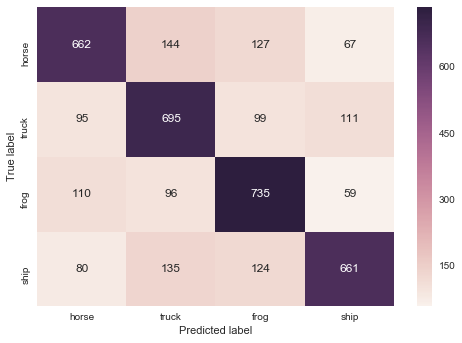

In [9]:
#representing confusion matrix as heatmap
df_conf = pd.DataFrame(results[best][1], index=target_names, columns=target_names)

print("\n\n Here is a nice representation of the confusion matrix of the best algorithm:\n\n")

heatmap = sns.heatmap(df_conf, annot=True,fmt="d")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## 5. Comments

Among all models, Random Forest produced by far the best accuracy for this data set! Actually, this is not unexpected. Some even argue that random forest is _the best_ classification algorithm. Although "the best" is a very strong word to use for any classification algorithm, I think random forest produces very good results in _most_ problems, and _usually_ outperforms others.

(As for reference, there are two relatively recent and interesting articles, both puplished in JMLR. While [Fernández-Delgado et al.(2014)](http://jmlr.org/papers/volume15/delgado14a/delgado14a.pdf) argue that "the classifiers most likely to be the bests are the random forest (RF) versions", [Wainberg et. al.(2016)](http://jmlr.org/papers/volume17/15-374/15-374.pdf) don't agree with them.)

In terms of image classes, as can be seen from the confusion matrix above, "frog" images were classified more accurately than all others, and the second best prediction (in terms of accuracy) were "truck" images.